In [2]:
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(f'Number of words: {len(words)}')                                      
print(f'Length of max word:{max(len(w) for w in words)}')
print(words[:8])

Number of words: 32033
Length of max word:15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [6]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

# create training, validation and test data sets 
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [7]:
# print the fist 20 examples 
for x,y in zip(Xtr[:20],Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x),'-->',itos[y.item()])


........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [8]:
# from "bigram-batch_norm.ipynb"

# .............................// linear layer // ............................................
class Linear:
    def __init__(self,fan_in,fan_out,bias=True):
        self.weight = torch.randn((fan_in,fan_out))/fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    
    def __call__(self,x):
        self.out = x @ self.weight 
        if self.bias is not None:
            self.out += self.bias 
        return self.out 
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
# .............................// batch norm layer // ..........................................

class BatchNorm1d:
    def __init__(self,dim,eps=1e-5,momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True 
        # trainable parameters 
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers 
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self,x):
        # forward pass 
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim,keepdim=True)    # batch mean 
            xvar = x.var(dim,keepdim=True)      # batch variance 
        else:
            xmean = self.running_mean
            xvar = self.running_var 
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps) # normalize to unit variance 
        self.out = self.gamma * xhat + self.beta
        # update the buffers 
        self.running_mean = (1-self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1-self.momentum) * self.running_var + self.momentum * xvar
        
        return self.out 
    
    def parameters(self):
        return [self.gamma,self.beta]

#...........................//tanh activation//................................................
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
#..........................//Embedding//......................................................
class Embedding:
    def __init__(self,num_embeddings,embedding_dim):
        self.weight = torch.randn((num_embeddings,embedding_dim))
        
    def __call__(self,IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
    
#.........................//flatten layer//...................................................
class FlattenConsecutive:
    def __init__(self,n):
        self.n = n
    
    def __call__(self,x):
        B,T,C = x.shape                     # for ex. (32,8,64)
        x = x.view(B,T//self.n,C*self.n)    # (32,2,4*64)-> we can think (32,2) as new batch size
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x 
        return self.out
    
    def parameters(self):
        return []
    
#........................//sequential class//..................................................
class Sequential:
    def __init__(self,layers):
        self.layers = layers 
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out 
    # collect all the learnable parameters (can be trained using GD) in the model 
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


### Flatten Layer

* [B,(1,2,3,4,5,6,7,8)] - > [B,(1,2),(3,4),(5,6),(7,8)]

* Input shapes: (B,8,10), output shape: (B,1). Note here 10 the embedding vector size 

* Previously we fed all the 8 chars into the MLP to get the output char, i.e. we flattened the input 8 chars into (B,80) and fed into linear layer. 

* Therefore too much information is fed to the network at once, so we can fed two chars at once to the network

* So the input shape can be arranged to (B,4,20), this means we we fed (B,4) batches of size 20 into the network, to predict (B) no of outputs 



In [9]:
# hierarchical network
n_embd = 24             # character embedding vectors dim
n_hidden = 128           # the number of neurons in the hidden layer of the MLP
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

76579


In [10]:
# train the model 

max_steps = 100000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 100000: 3.2911
  10000/ 100000: 1.8511
  20000/ 100000: 1.8479
  30000/ 100000: 1.8753
  40000/ 100000: 1.7290
  50000/ 100000: 2.0387
  60000/ 100000: 1.9906
  70000/ 100000: 1.9445
  80000/ 100000: 1.9576
  90000/ 100000: 1.8570


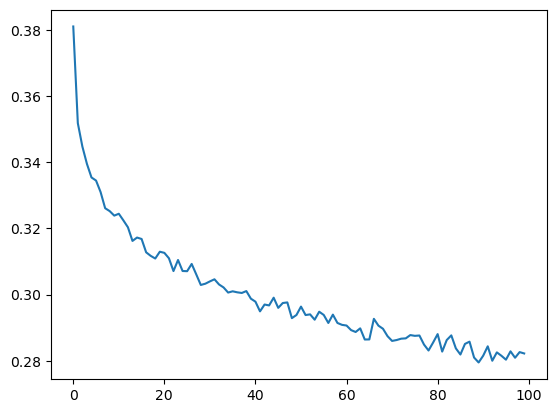

In [17]:
# loss curve 
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [19]:
# put layers into eval mode
for layer in model.layers:
    layer.training = False 


In [21]:
# evaluate the loss 
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val'  :(Xdev,Ydev),
        'test' :(Xte,Yte)
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')

train 1.8973814249038696
val 2.051798105239868


In [27]:
# sample from the model 

for _ in range(20):
    out = []
    context = [0]*block_size 
    while True:
        # forward pass 
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits,dim=1)
        
        # sample from chars 
        ix = torch.multinomial(probs,num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        # stop if model pick '.'
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))
    

shren.
samarah.
yahmina.
lovelyn.
anthoni.
efaoloz.
mayar.
elise.
cheza.
melon.
isaacwe.
abduland.
kanna.
alisky.
sarverlynn.
meenah.
farra.
feanavi.
leilani.
jomi.
